In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

print(os.getcwd())

/Users/ika/Desktop/Fall 2024/CS 7300/assignment_two


## Question One -- A1Q1 Data

In [2]:
train_data = pd.read_csv('./A1Q1_Data.csv')
train_data.head(2)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa


In [4]:
le = LabelEncoder()
train_data['variety'] = le.fit_transform(train_data['variety'])
train_data.head(3)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0


In [67]:
X = train_data.drop(columns=['variety'], axis = 1)
y = train_data.variety

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)


print(f"X_train shape: {X_train.shape} \nX_test shape: {X_test.shape} \nX_valid shape: {X_valid.shape} \ny_train shape: {y_train.shape} \ny_valid shape: {y_valid.shape} \ny_test shape: {y_test.shape}")

X_train shape: (105, 4) 
X_test shape: (15, 4) 
X_valid shape: (30, 4) 
y_train shape: (105,) 
y_valid shape: (30,) 
y_test shape: (15,)


```
When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. 
```

In [69]:
distanc_metrics = ['minkowski', 'euclidean', 'manhattan', 'cosine']
def knn_classifier_with_best_k_choice(X_train, X_valid, y_train, y_valid, distances):
    history = {}
    best_model = None
    best_distance_metric = None
    best_k = 0
    best_metric = -1

    for distance_metric in distances:
        history[distance_metric] = []
        
        for nn in range(1, 16):  
            model = KNeighborsClassifier(n_neighbors=nn, metric=distance_metric)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_valid)
            
            metric = f1_score(y_valid, y_pred, average='macro') 
            history[distance_metric].append(metric) 
            
            if metric > best_metric:
                best_metric = metric
                best_model = model
                best_distance_metric = distance_metric
                best_k = nn

    return history, best_model, best_distance_metric, best_k

In [82]:
history, best_model, best_distance_metric, best_k = knn_classifier_with_best_k_choice(X_train= X_train,
                                                                                      X_valid=X_valid,
                                                                                      y_train=y_train,
                                                                                      y_valid= y_valid,
                                                                                      distances=distanc_metrics)

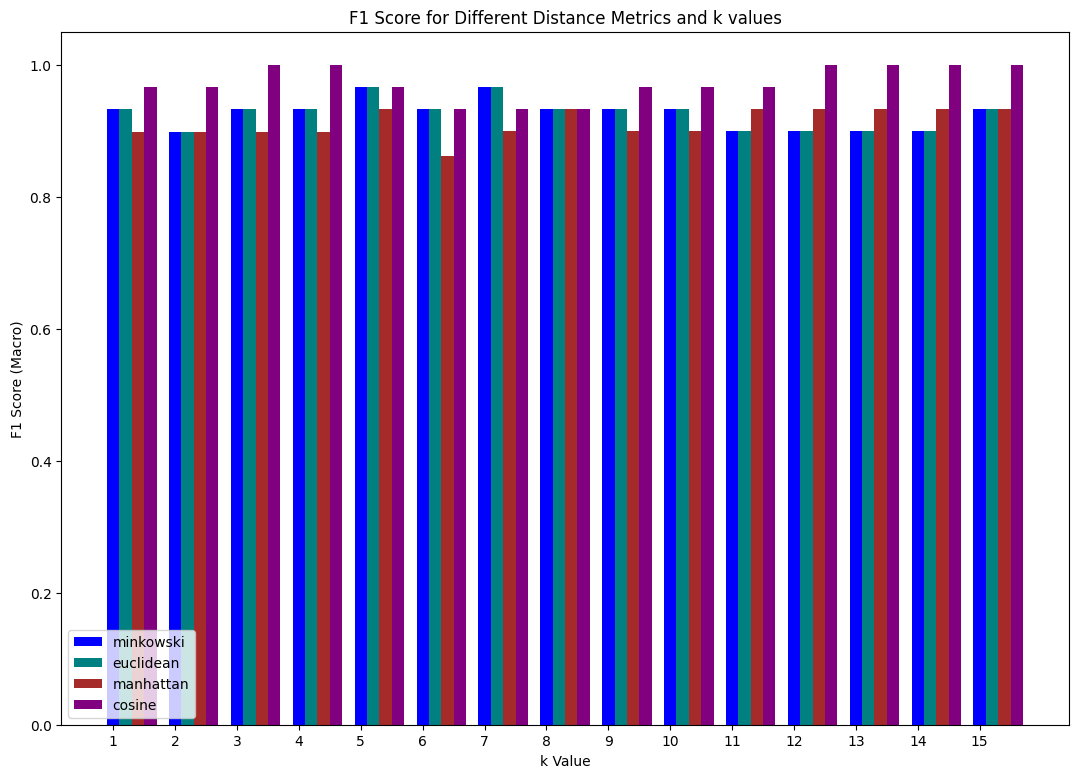

In [114]:
def plot_f1_scores(history):
    k_values = list(range(1, 16))

    plt.figure(figsize=(13, 9))
    colors = ['blue', 'teal', 'brown', 'purple']

    for i, (distance_metric, metrics) in enumerate(history.items()):
        plt.bar(np.array(k_values) + i*0.2, metrics, width=0.2, label=f'{distance_metric}', color=colors[i])

    plt.xlabel('k Value')
    plt.ylabel('F1 Score (Macro)')
    plt.title('F1 Score for Different Distance Metrics and k values')
    plt.xticks(k_values)
    plt.legend(loc='lower left')
    plt.show()

plot_f1_scores(history)


- Overall `cosine` distance metric performs best on the average across all the distance metrics. 

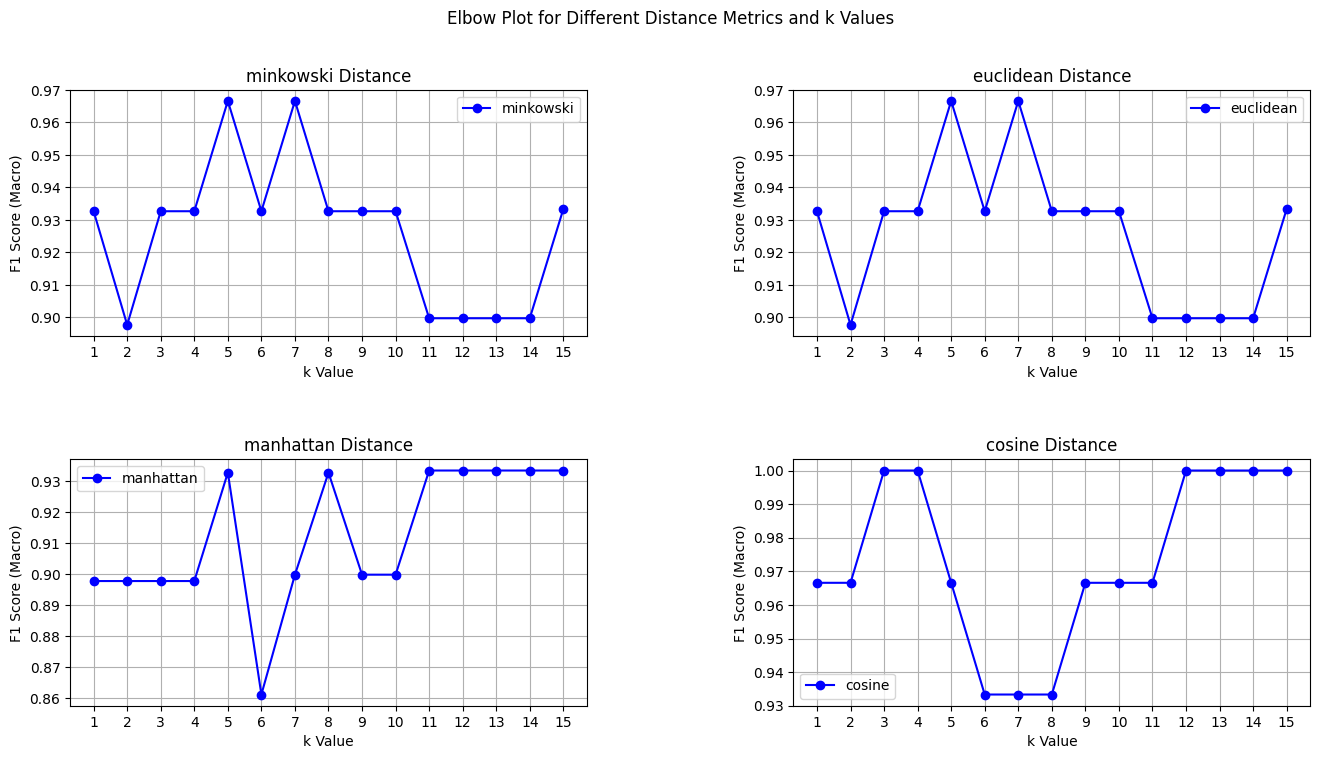

In [113]:
def plot_elbow(history):
    k_values = list(range(1, 16))
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    axes = axes.flatten()
    
    plt.subplots_adjust(wspace=0.4, hspace=0.5)

    for i, (distance_metric, metrics) in enumerate(history.items()):
        axes[i].plot(k_values, metrics, marker='o', linestyle='-', color='blue', label=f'{distance_metric}')
        axes[i].set_title(f'{distance_metric} Distance')
        axes[i].set_xlabel('k Value')
        axes[i].set_ylabel('F1 Score (Macro)')
        axes[i].grid(True)
        axes[i].set_xticks(k_values)
        axes[i].legend()

    plt.suptitle("Elbow Plot for Different Distance Metrics and k Values")
    plt.show()

plot_elbow(history)


- `Cosine Distance` appears to be the most reliable distance metric based on these plots, with a perfect `F1` score at $k=3$ and consistent performance across higher values of $k$.

- For `Minkowski` and `Euclidean distances`, it's best to use $k$ values between $3$ and $7$ to avoid the significant drop in performance that occurs at higher $k$ values.

- `Manhattan Distance` is another good option, particularly for $k$ values between $5$ and $10$.

## Question Two -- A1Q2 Data

In [157]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [120]:
traning_data_q2 = pd.read_csv('./A1Q2_Trarin_Data.csv')
test_data_q2 = pd.read_csv('./A1Q2_Test_Data.csv')
print(traning_data_q2.shape)
traning_data_q2.head(2)

(333, 15)


,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.9,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6


In [119]:
X = traning_data_q2.drop(columns= [ 'medv'], axis = 1).values
y = traning_data_q2.medv.values

In [158]:
def ridge_regression_with_best_k_and_alpha(X_train, y_train, k_values):
    history = {}
    best_model = None
    # best_alpha = 0
    best_k = 0
    best_metric = float('inf')

    for k in k_values:
        scaler = StandardScaler()
        history[k] = []
        
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        
        # for alpha in alphas:
        #     history[k][alpha] = []  
            
        fold_metrics = []  # MSE values across folds
            
        for train_index, valid_index in kf.split(X_train):
            X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
            y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]

            X_train_fold = scaler.fit_transform(X_train_fold)
            X_valid_fold = scaler.fit_transform(X_valid_fold)
            
            model = Ridge()
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_valid_fold)
            
            metric = mean_squared_error(y_valid_fold, y_pred)
            fold_metrics.append(metric)
        
        avg_metric = np.mean(fold_metrics)
        history[k].append(avg_metric)
        
        if avg_metric < best_metric: # lower is good
            best_metric = avg_metric
            best_model = model
            # best_alpha = alpha
            best_k = k

    return history, best_model, best_k

In [163]:
k_values = list(range(5, 35, 5))
history, best_model, best_k = ridge_regression_with_best_k_and_alpha(X_train=X, 
                                                                     y_train=y, 
                                                                     k_values=k_values)

In [165]:
test_prediction = best_model.predict(test_data_q2.values)
test_prediction[:20]

array([  20.94156988,   42.38789155, -149.72679432, -209.96493709,
       -151.77230768, -156.00169087, -131.53183806, -165.25312959,
       -269.61700298, -180.08001244, -159.73750242, -161.13691216,
       -397.56806899, -219.88855919,  -75.28435648, -102.24668778,
        -60.91709612,   28.51039487, -120.36824663,   28.1659817 ])

In [161]:
feature_names = [f'{i}' for i in list(traning_data_q2.columns)[:-1]]
coefficients = best_model.coef_

importance_df = pd.DataFrame({
                    'Feature': feature_names,
                    'Coefficient': coefficients
                }).sort_values(by='Coefficient', ascending=False).reset_index(drop=True)

importance_df

,Feature,Coefficient
0,rm,2.910028
1,rad,2.568290
2,black,1.167854
3,zn,0.998408
4,chas,0.969388
5,indus,0.490265
6,crim,-0.081887
7,age,-0.524647
8,ID,-0.624095
9,tax,-1.620008


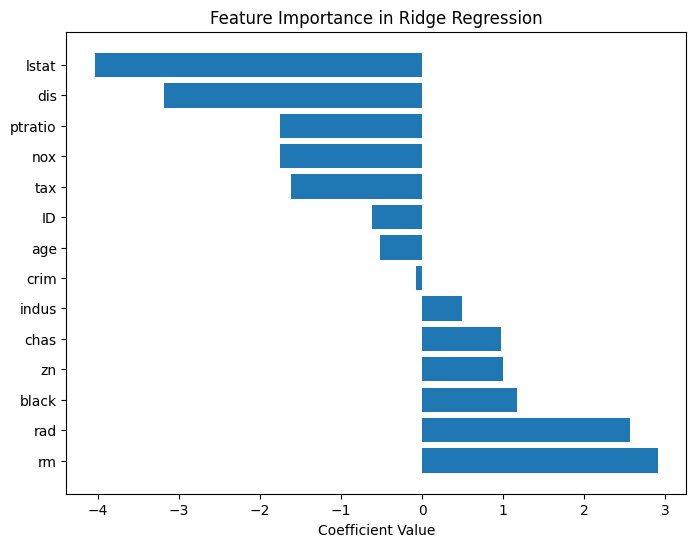

In [162]:
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Ridge Regression')
plt.show()

- `lstat` has the largest influence on the model's prediction, and since its coefficient is negative, it likely represents a feature that, as it increases, the target variable, the house price decreases significantly. 

- `rm` has the largest positive impact on the target variable, meaning houses with more rooms `(rm)` tend to have higher predicted values.

- Features like `zn`, `black`, and `chas` have relatively small coefficients, meaning they have less influence on the target compared to other features.